<a href="https://colab.research.google.com/github/claredavies/DataEngAPITesting/blob/master/AnamolyDetection/HTTP_Response/Supervised/Monitor_Latency_StatusCode_Supervised_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [63]:
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
!pip install pyod

from pandas import read_csv
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, average_precision_score, roc_auc_score

from pyod.models.mad import MAD
from pyod.models.knn import KNN
from pyod.models.lof import LOF

# Read in data

In [96]:
train = pd.read_csv("train.csv")
print(train.head())

       Time Method  Code  Delay  Y
0  11:00:00    GET   200  15000  1
1  11:00:01   POST   201  15000  1
2  11:00:02   POST   201  16000  1
3  11:00:03    GET   200  16000  1
4  11:00:04    GET   200  18000  1


In [97]:
print(train['Code'].unique())

[200 201 404 302 204 400 500]


# Data Processing

In [98]:
train['Code'].value_counts()

200    22514
201     1497
400      590
404      484
204      278
302       46
500       43
Name: Code, dtype: int64

In [99]:
one_hot_encoded_train = pd.get_dummies(train, columns = ['Code'])
print(one_hot_encoded_train)

           Time Method  Delay  Y  Code_200  Code_201  Code_204  Code_302  \
0      11:00:00    GET  15000  1         1         0         0         0   
1      11:00:01   POST  15000  1         0         1         0         0   
2      11:00:02   POST  16000  1         0         1         0         0   
3      11:00:03    GET  16000  1         1         0         0         0   
4      11:00:04    GET  18000  1         1         0         0         0   
...         ...    ...    ... ..       ...       ...       ...       ...   
25447  18:03:23    GET  15000  1         1         0         0         0   
25448  18:03:24    GET  16000  1         1         0         0         0   
25449  18:03:25    GET  15000  1         1         0         0         0   
25450  18:03:26    GET  16000  1         1         0         0         0   
25451  18:03:27    GET  15000  1         1         0         0         0   

       Code_400  Code_404  Code_500  
0             0         0         0  
1          

In [100]:
one_hot_encoded_train = pd.get_dummies(one_hot_encoded_train, columns = ['Method'])

In [101]:
train = one_hot_encoded_train.drop('Time', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [102]:
print(train.head)

<bound method NDFrame.head of        Delay  Y  Code_200  Code_201  Code_204  Code_302  Code_400  Code_404  \
0      15000  1         1         0         0         0         0         0   
1      15000  1         0         1         0         0         0         0   
2      16000  1         0         1         0         0         0         0   
3      16000  1         1         0         0         0         0         0   
4      18000  1         1         0         0         0         0         0   
...      ... ..       ...       ...       ...       ...       ...       ...   
25447  15000  1         1         0         0         0         0         0   
25448  16000  1         1         0         0         0         0         0   
25449  15000  1         1         0         0         0         0         0   
25450  16000  1         1         0         0         0         0         0   
25451  15000  1         1         0         0         0         0         0   

       Code_500  Meth

In [103]:
y_train=train[["Y"]]
X_train=train.drop("Y", 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [104]:
test = pd.read_csv("test.csv")
one_hot_encoded_test = pd.get_dummies(test, columns = ['Code'])
one_hot_encoded_test = pd.get_dummies(one_hot_encoded_test, columns = ['Method'])
test = one_hot_encoded_test.drop('Time', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


In [105]:
y_test=test[["Y"]]
X_test=test.drop("Y", 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [106]:
print(y_train.head())
print(X_train.head())

   Y
0  1
1  1
2  1
3  1
4  1
   Delay  Code_200  Code_201  Code_204  Code_302  Code_400  Code_404  \
0  15000         1         0         0         0         0         0   
1  15000         0         1         0         0         0         0   
2  16000         0         1         0         0         0         0   
3  16000         1         0         0         0         0         0   
4  18000         1         0         0         0         0         0   

   Code_500  Method_DELETE  Method_GET  Method_HEAD  Method_OPTIONS  \
0         0              0           1            0               0   
1         0              0           0            0               0   
2         0              0           0            0               0   
3         0              0           1            0               0   
4         0              0           1            0               0   

   Method_PATCH  Method_POST  Method_PUT  
0             0            0           0  
1             0         

In [107]:
y_train.loc[y_train["Y"] == -1, "Y"] = 0
y_test.loc[y_test["Y"] == -1, "Y"] = 0

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


# Metrics

In [83]:
def get_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  return cm

def plot_cm(ax,labels, predictions,title, p=0.5):
  tick_labels = ['Y', 'N']
  cm = get_cm(labels, predictions, p)
  sns.heatmap(cm, annot=True, fmt="d",ax=ax)
  ax.title.set_text(title)
  ax.set_xticklabels(tick_labels)
  ax.set_yticklabels(tick_labels)

# Resampling

Anamoly Resampled 25408
Not-Anamoly Resampled 44
Subscribe Resampled proportion 99.83%


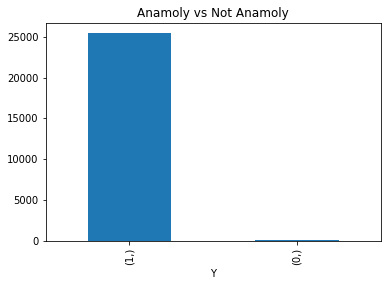

In [109]:
def percentage(part, whole):
  return 100 * float(part) / float(whole)

anamoly, not_anamoly = y_train.value_counts()
print(f'Anamoly Resampled {anamoly}')
print(f'Not-Anamoly Resampled {not_anamoly}')
print(f'Subscribe Resampled proportion {round(percentage(anamoly,anamoly + not_anamoly), 2)}%')

y_train.value_counts().plot(kind="bar", title="Anamoly vs Not Anamoly");

In [110]:
print(y_train['Y'].unique())
print(y_train['Y'].unique())

[1 0]
[1 0]


In [111]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0,  k_neighbors=2)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


Anamoly Resampled 25408
Not-Anamoly Resampled 25408
Subscribe Resampled proportion 50.0%


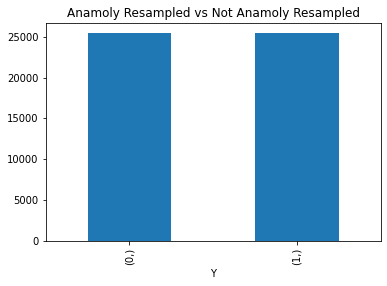

In [112]:
def percentage(part, whole):
  return 100 * float(part) / float(whole)

anamoly_resampled, not_anamoly_resampled = y_train_resampled.value_counts()
print(f'Anamoly Resampled {anamoly_resampled}')
print(f'Not-Anamoly Resampled {not_anamoly_resampled}')
print(f'Subscribe Resampled proportion {round(percentage(anamoly_resampled,anamoly_resampled + not_anamoly_resampled), 2)}%')

y_train_resampled.value_counts().plot(kind="bar", title="Anamoly Resampled vs Not Anamoly Resampled");

In [113]:
print(y_train_resampled.head(100))

    Y
0   1
1   1
2   1
3   1
4   1
.. ..
95  1
96  1
97  1
98  1
99  1

[100 rows x 1 columns]


# Weighting

In [114]:
anamoly_count, not_anamoly_count = np.bincount(y_train.Y)
total_count = len(y_train.Y)

weight_anamoly = ((1 / anamoly_count) * (total_count) / 2.0 )
weight_not_anamoly = (((1 / not_anamoly_count) * (total_count) / 2.0 )) 
print("Weight Anamoly:  " + str(weight_anamoly))
print("Weight Not Anamoly:  " + str(weight_not_anamoly))
class_weights = {0: weight_anamoly, 1: weight_not_anamoly}

Weight Anamoly:  289.22727272727275
Weight Not Anamoly:  0.5008658690176322


# ML

In [116]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from imblearn.ensemble import BalancedRandomForestClassifier

models = {}

models['LR'] = LogisticRegression(solver='lbfgs',class_weight=class_weights)
models['RandomForest'] = BalancedRandomForestClassifier(max_depth=2, random_state=0,class_weight=class_weights)
models['KNN'] = KNeighborsClassifier( weights='distance')
models['SVM'] = SVC(gamma='auto',class_weight=class_weights)

accuracy, f1, roc_auc, predictions, AnamolyCorrectFraction, NonAnamolyCorrectFraction = {}, {}, {}, {}, {}, {}
for key in models.keys():
    models[key].fit(X_train, y_train['Y'])
    predictions[key] = models[key].predict(X_test)

    accuracy[key] = accuracy_score(y_test['Y'], predictions[key])
    f1[key] = f1_score(y_test['Y'], predictions[key])
    roc_auc[key] = roc_auc_score(y_test['Y'], predictions[key])
    tn, fp, fn, tp = confusion_matrix(y_test, predictions[key]).ravel()
    AnamolyCorrectFraction[key] = (tn/(tn+fp))
    NonAnamolyCorrectFraction[key] = (tp/(tp+fn))


              Accuracy  f1_score   roc_auc  AnamolyCorrectFraction  NonAnamolyCorrectFraction
LR            0.998427  0.999212  0.999213                     1.0                   0.998426
RandomForest  0.084303  0.154271  0.541791                     1.0                   0.083583
KNN           1.000000  1.000000  1.000000                     1.0                   1.000000
SVM           1.000000  1.000000  1.000000                     1.0                   1.000000


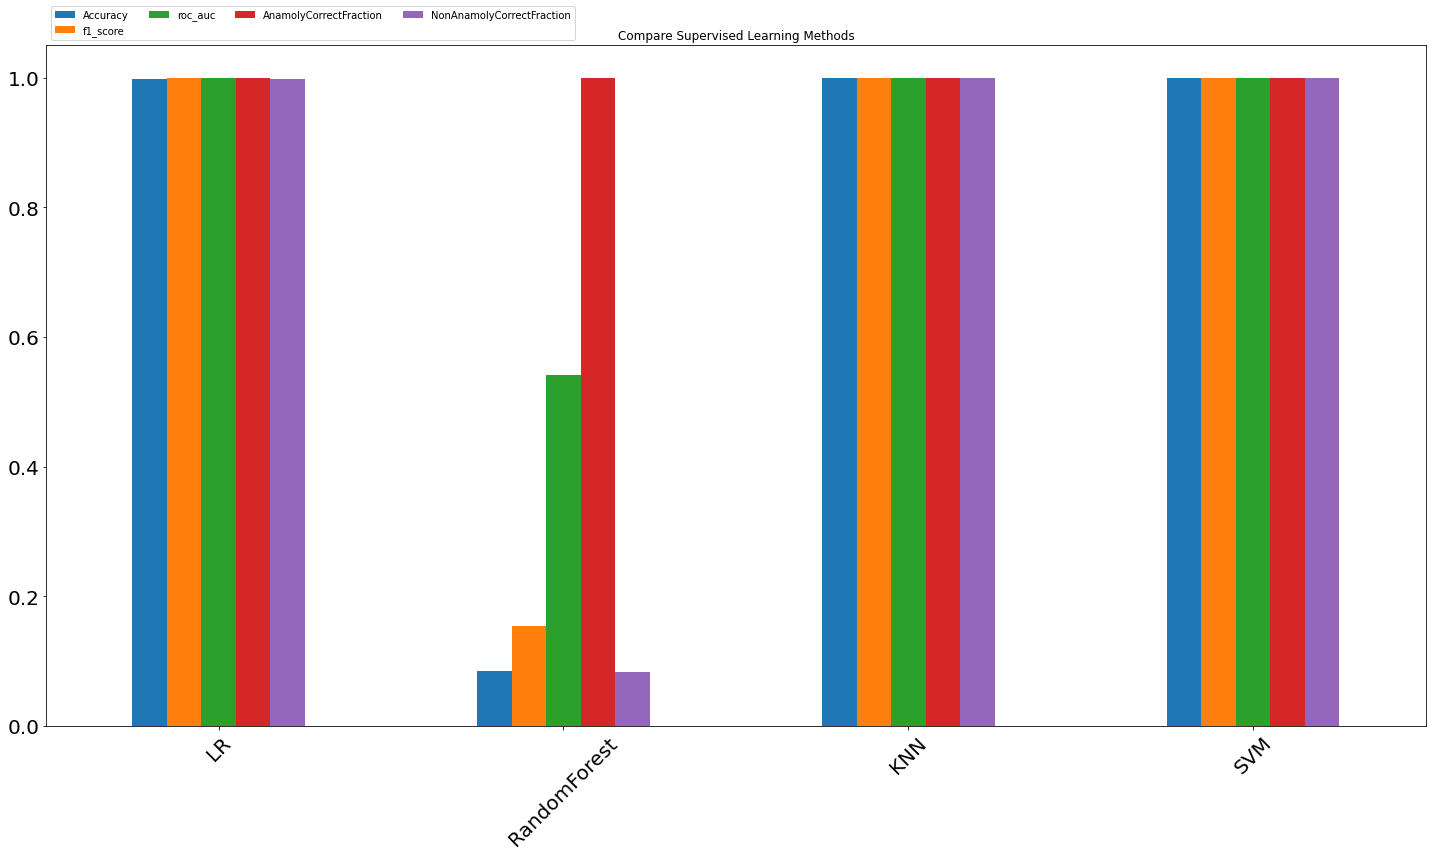

In [117]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'f1_score', 'roc_auc','AnamolyCorrectFraction','NonAnamolyCorrectFraction'])
df_model['Accuracy'] = accuracy.values()
df_model['f1_score'] = f1.values()
df_model['roc_auc'] = roc_auc.values()
df_model['AnamolyCorrectFraction'] =  AnamolyCorrectFraction.values()
df_model['NonAnamolyCorrectFraction'] = NonAnamolyCorrectFraction.values()

print(df_model)

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
ax  = df_model.plot.bar(rot=45,figsize=(20,12),title="Compare Supervised Learning Methods")
ax.legend(ncol= len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': 10})
plt.tight_layout()

In [118]:
evaluation_df = pd.DataFrame(confusion_matrix(y_test, predictions['KNN']), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

In [119]:
print(evaluation_df)

                 Predicted Negative  Predicted Positive
Actual Negative                   5                   0
Actual Positive                   0                6353


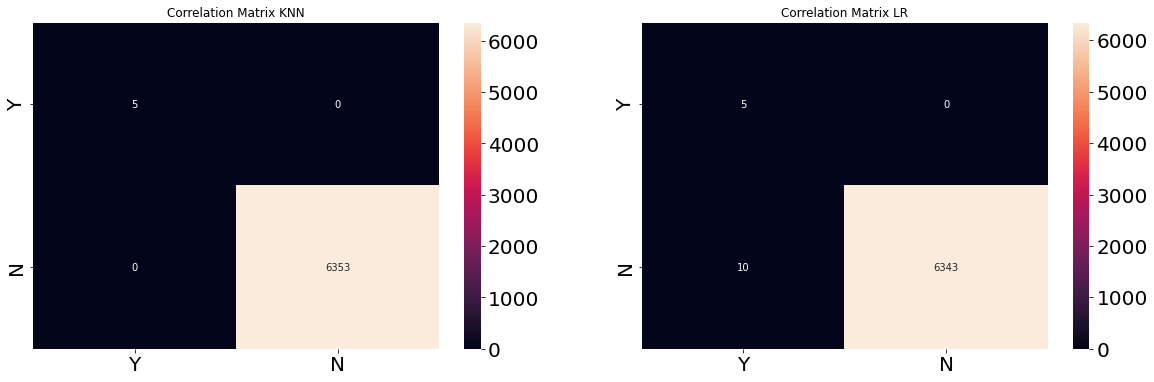

In [120]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,6))
plot_cm(ax1,y_test, predictions['KNN'],"Correlation Matrix KNN")
plot_cm(ax2,y_test, predictions['LR'],"Correlation Matrix LR")